<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics Education

# LiDAR Uncertainty at SOAP and SJER NEON sites

## The Soap Site
![Soaproot panorama](img/Soaproot_pano.jpeg)
Image Credit: National Ecological Observation Network, available at https://www.neonscience.org/field-sites/soap

## The SJER Site
![SJER panorama](img/sjer_site.jpeg)
Image Credit: National Ecological Observation Network, available at https://www.neonscience.org/field-sites/sjer

In [8]:
import os
import pathlib

import earthpy as et 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterstats as rs
import xarray as xr
import rioxarray as rxr
import seaborn as sns

import clean

# download the data from EarthPy
et.data.get_data('spatial-vector-lidar')

# set home directory
home_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'spatial-vector-lidar'
)
os.chdir(home_dir)   

### NEONDataLoader object:
    - takes:
        - name of dataset
        - id column name
        - dictionary of changes to make to paths
    - has:
        - name of the dataset
        - id column name
        - paths
        - LiDAR GeoDataFrame
        - insitu DataFrame
        - merged GeoDataFrame
    - does: 
        - loads LiDAR GeoDataFrame
        - loads insitu DataFrame
        - Merges insitu and LiDAR data
        - plots the data
        - (caching)
        - (save plot to a file)
        

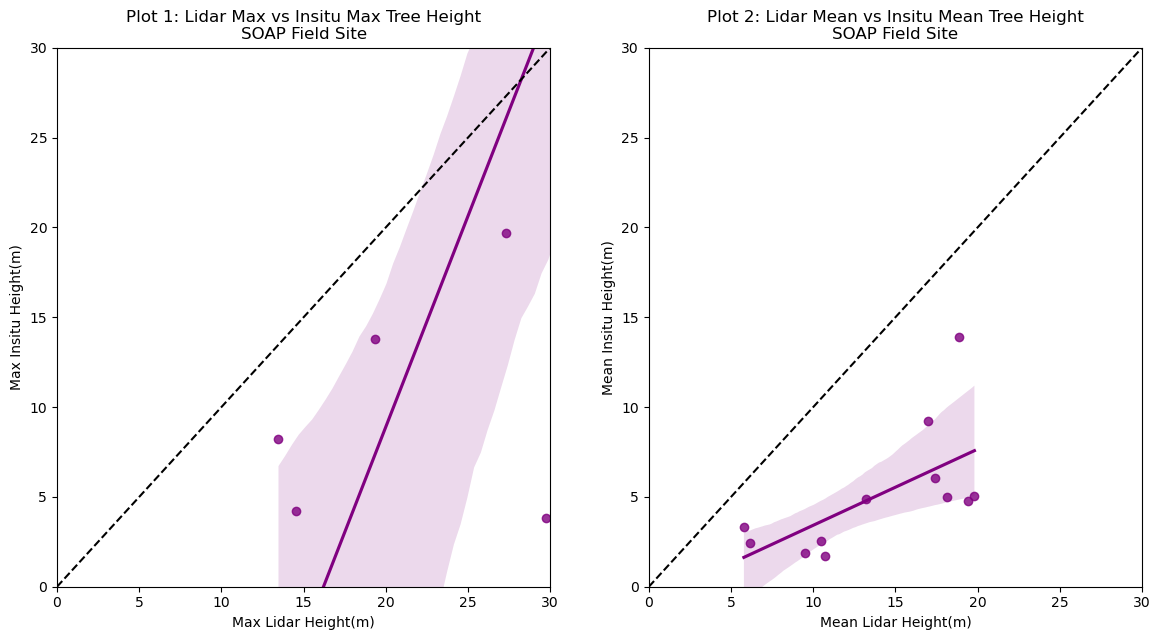

In [87]:
class NEONDataLoader(object):
    """Parent class to load NEON height data."""
    
    base_dir_tmpl = os.path.join(
        'california',
        'neon-{site_name_low}-site')
    insitu_path_tmpl = os.path.join(
        '{base_dir}', '2013',
        'insitu',
        'veg{seperator}structure',
        'D17_2013_{site_name_up}_vegStr.csv')
    plots_path_tmpl = os.path.join(
        '{base_dir}',
        'vector_data',
        '{site_name_up}{plot}_centroids.shp')
    chm_path_tmpl = os.path.join(
        '{base_dir}', '2013',
        'lidar',
        '{site_name_low}_lidarCHM.tif')
    
    def __init__(
        self, site_name, id_col_name, formatting_dict,
        id_modifier=None):
        self.site_name = site_name
        self.id_col_name = id_col_name
        self.id_modifier = id_modifier
        self.formatting_dict = formatting_dict
        self.formatting_dict['site_name_low'] = site_name.lower()
        self.formatting_dict['site_name_up'] = site_name.upper()
        self.formatting_dict['base_dir'] = (
            self.base_dir_tmpl.format(**self.formatting_dict))
        
        self.insitu_path = self.insitu_path_tmpl.format(**self.formatting_dict)
        self.chm_path = self.chm_path_tmpl.format(**self.formatting_dict)
        self.plots_path = self.plots_path_tmpl.format(**self.formatting_dict)
        
        self._insitu_height_stats = None
        self._lidar_chm_stats = None
        self._height_stats = None

    @property
    def lidar_chm_stats(self):
        """
        Calculate max and mean tree height from LiDAR.
        """
        if self._lidar_chm_stats is None:
            plots_gdf = gpd.read_file(self.plots_path)
            plots_gdf.geometry = plots_gdf.geometry.buffer(20)

            # Calculate the zonal stats
            chm_stats = rs.zonal_stats(
                plots_gdf, 
                self.chm_path,
                stats=['mean', 'max'],
                geojson_out=True,
                nodata=0,
                copy_properties=True
            )
            self._lidar_chm_stats = gpd.GeoDataFrame.from_features(chm_stats)
            lidar_mean_max = self._lidar_chm_stats.rename(
                columns={'max':'lidar_max', 'mean':'lidar_mean'},
                inplace=True)
            if not self.id_modifier is None:
                self._lidar_chm_stats[self.id_col_name] = (
                    self._lidar_chm_stats[self.id_col_name].apply(self.id_modifier))
        return self._lidar_chm_stats
    
    @property
    def insitu_height_stats(self):
        """
        Calculate insitu tree height data max and mean.
        """
        if self._insitu_height_stats is None:
            self._insitu_height_stats = (pd.read_csv(self.insitu_path)
                          .groupby('plotid')
                          .stemheight
                          .agg(['max','mean'])
                         .rename(columns={
                                 'max':'insitu_max', 'mean':'insitu_mean'}))
        return self._insitu_height_stats 
    
    @property
    def height_stats(self):
        """
        Calculate lidar and insitu height stats on a merged dataframe.
        """
        if self._height_stats is None:
            self._height_stats = (
                self.lidar_chm_stats
                .merge(self.insitu_height_stats,
                       right_index=True,
                       left_on=self.id_col_name))

        return self._height_stats
    
    def plot_comparisons(self):
    
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 7))
        # ax1.scatter(sjer_df.lidar_mean, sjer_df.insitu_mean)
        sns.regplot(data=self.height_stats, x='lidar_max',y='insitu_max', 
                   color='purple',
                   ax=ax1)
        ax1.plot((0,1), (0,1), transform=ax1.transAxes, ls='--', c='k')
        ax1.set(xlabel='Max Lidar Height(m)',ylabel='Max Insitu Height(m)',
               title=('Plot 1: Lidar Max vs Insitu Max Tree Height\n'
                     '{} Field Site').format(self.site_name),
               ylim=(0,30),
               xlim=(0,30))

        sns.regplot(data=self.height_stats, x='lidar_mean',y='insitu_mean', 
                   color='purple',
                   ax=ax2)
        ax2.set(xlabel='Mean Lidar Height(m)',ylabel='Mean Insitu Height(m)',
               title=('Plot 2: Lidar Mean vs Insitu Mean Tree Height\n'
                     '{} Field Site').format(self.site_name),
                ylim=(0,30),
                xlim=(0,30))
        ax2.plot((0,1), (0,1), transform=ax2.transAxes, ls='--', c='k')

    


soap_data_loader = NEONDataLoader(
    'SOAP', 'ID', {'seperator':'-', 'plot': ''},
    lambda id: 'SOAP' + str(id))
soap_data_loader.plot_comparisons()

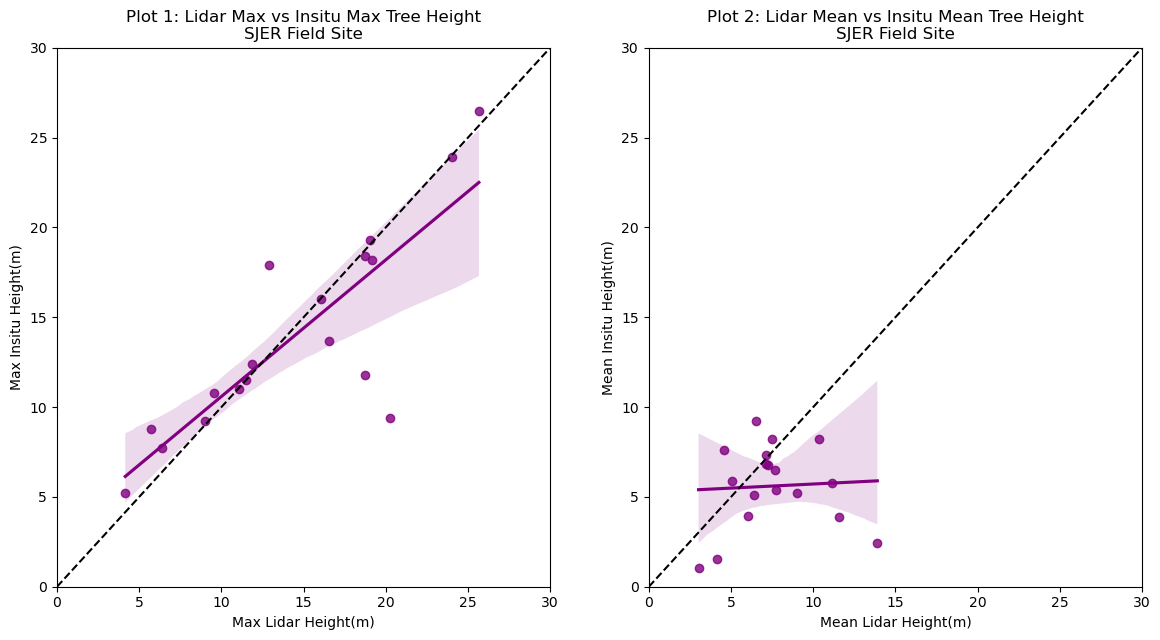

In [86]:
sjer_data_loader = NEONDataLoader(
    'SJER', 'Plot_ID', {'seperator':'_', 'plot': '_plot'})
sjer_data_loader.plot_comparisons()